In [1]:
import os
import sys
import time
import platform
import settings

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['font.family'] = settings.FONT_FAMILY
plt.rcParams['font.size'] = settings.FONT_SIZE
plt.rcParams['figure.dpi'] = 300

from dataloader import DatasetGenerator, get_decathlon_filelist
from model import UNet2D, dice_coefficient, iou, sensitivity, specificity, hausdorff

print("Platform:              {}".format(platform.platform()))
print("Python version:        {}".format(sys.version))
print("TensorFlow version:    {}".format(tf.__version__))
gpu_status = "Available" if tf.config.list_physical_devices("GPU") else "Not Available"
color = "\033[92m" if gpu_status == "Available" else "\033[91m"
reset = "\033[0m"
print(f"GPU Status:            {color}{gpu_status}{reset}")

Platform:              macOS-15.1-arm64-arm-64bit
Python version:        3.10.8 (v3.10.8:aaaf517424, Oct 11 2022, 10:14:40) [Clang 13.0.0 (clang-1300.0.29.30)]
TensorFlow version:    2.15.0
GPU Status:            Available


In [2]:
saved_model_dir = os.path.join(settings.OUTPUT_PATH, settings.INFERENCE_FILENAME)
data_path = settings.TEST_DATA_PATH
crop_dim = settings.CROP_DIM
batch_size = settings.BATCH_SIZE
seed = settings.SEED
train_test_split = 1.0  # Use the entire BraTS2017 dataset for testing

In [3]:
testFiles, _, _ = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)
ds_test = DatasetGenerator(testFiles,
                           batch_size=batch_size,
                           crop_dim=(crop_dim, crop_dim),
                           augment=False,
                           seed=seed,
                           dim=4
                           )


******************************
Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 484
Number of validation files = 0
Number of testing files    = 0


In [4]:
model = keras.models.load_model(saved_model_dir, compile=True, custom_objects=UNet2D().custom_objects)

Data format = channels_last


2024-11-04 20:16:40.863423: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-04 20:16:40.863453: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-04 20:16:40.863458: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-04 20:16:40.863487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-04 20:16:40.863501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
metrics = {
    "Dice Coefficient": dice_coefficient,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
}


def find_largest_tumor_slice(msk):
    return np.argmax(np.sum(np.sum(msk[:, :, :, 0], axis=1), axis=1))


def plot_image_subplot(img, idx, title, subplot_position):
    plt.subplot(1, 4, subplot_position)
    plt.axis("off")
    plt.imshow(img[idx, :, :, 0], cmap="gist_gray", origin="lower")
    plt.title(title)


def plot_mask_subplot(msk, idx, title, subplot_position):
    plt.subplot(1, 4, subplot_position)
    plt.axis("off")
    plt.imshow(msk[idx, :, :], cmap="gist_gray", origin="lower")
    plt.title(title)


def plot_prediction_subplot(prediction, idx, dice_coef, title, subplot_position):
    plt.subplot(1, 4, subplot_position)
    plt.axis("off")
    plt.imshow(prediction[0, :, :, 0], cmap="gist_gray", origin="lower")
    plt.title(f"{title}")


def plot_overlay_subplot(prediction, mask, idx, title, subplot_position):
    plt.subplot(1, 4, subplot_position)
    plt.axis("off")

    prediction = np.squeeze(prediction)
    mask = np.squeeze(mask[idx])

    if prediction.shape != mask.shape:
        raise ValueError("Prediction and mask must have the same shape")

    prediction = np.round(prediction).astype(np.uint8)

    overlay = np.zeros_like(prediction)
    overlay[(mask == 1) & (prediction == 1)] = 1  # Correctly segmented (green)
    overlay[(mask == 1) & (prediction == 0)] = 2  # Missing (purple)
    overlay[(mask == 0) & (prediction == 1)] = 3  # False positive (red)

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'purple', 'red'])
    bounds = [0, 1, 2, 3, 4]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    plt.imshow(overlay, cmap=cmap, norm=norm, origin="lower")
    plt.title(title)


def plot_results(ds):
    plt.figure(figsize=(15, 10))

    img, msk = next(ds.ds)
    idx = find_largest_tumor_slice(msk)

    plot_image_subplot(img, idx, f"MRI {idx}", 1)
    plot_mask_subplot(msk, idx, "Ground truth", 2)

    print(f"Index {idx}: ", end="")

    start_time = time.time()
    prediction = model.predict(img[[idx]], verbose=0)
    elapsed_time = 1000.0 * (time.time() - start_time)
    print(f"Elapsed time = {elapsed_time:.4f} msecs, ", end="")
    
    # print(msk[idx].shape, prediction.shape)

    dice_coef = dice_coefficient(msk[idx], prediction)
    iou_score = iou(msk[idx], np.squeeze(prediction, axis=0))
    sensitivity_score = sensitivity(msk[idx], np.squeeze(prediction, axis=0))
    specificity_score = specificity(msk[idx], np.squeeze(prediction, axis=0))

    print(f"Dice coefficient = {dice_coef:.4f}, ", end="")
    print(f"Sensitivity = {sensitivity_score:.4f}, ", end="")
    print(f"Specificity = {specificity_score:.4f}", end="")

    plot_prediction_subplot(prediction, idx, dice_coef, "Prediction", 3)
    plot_overlay_subplot(prediction, msk, idx, "Overlay", 4)

    metrics_text = (f"Dice: {dice_coef:.4f}\n"
                    f"Sensitivity: {sensitivity_score:.4f}\n"
                    f"Specificity: {specificity_score:.4f}")

    plt.subplot(1, 4, 4)
    plt.axis("off")
    plt.text(2, 2, metrics_text, ha='left', va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.show()

Index 80: 

2024-11-04 20:16:42.128424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Elapsed time = 215.1244 msecs, Dice coefficient = 0.9646, Sensitivity = 0.9732, Specificity = 0.9893

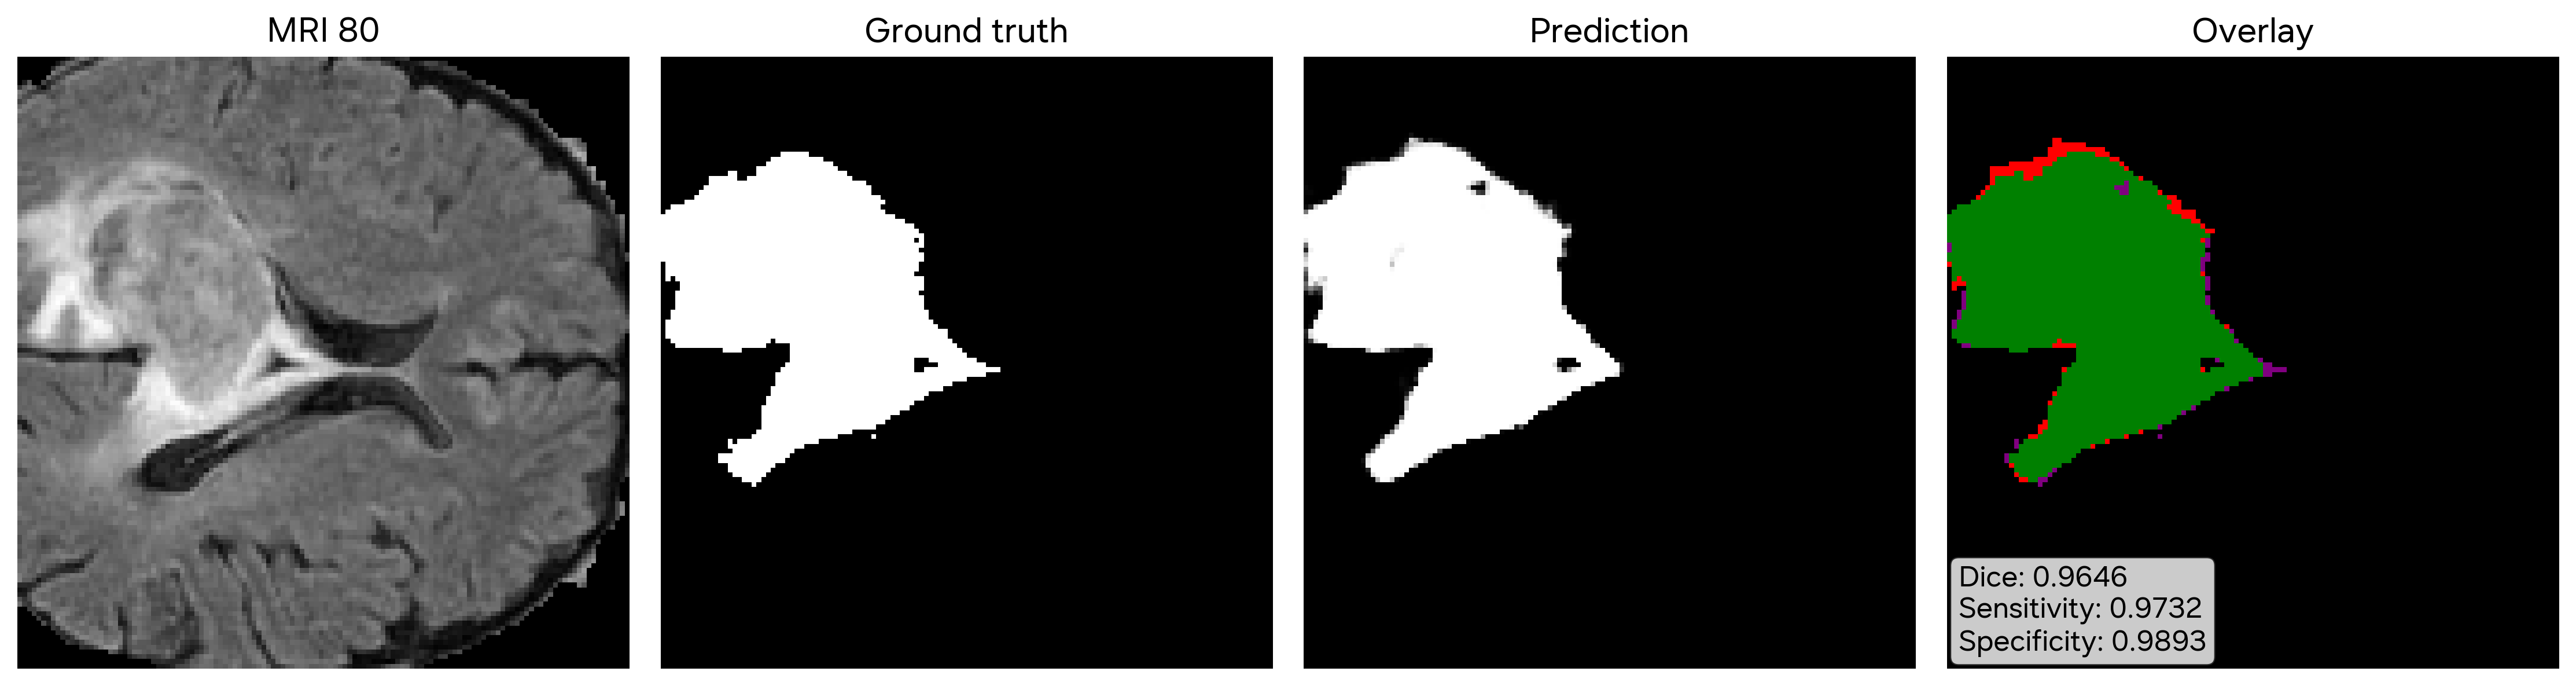

Index 52: Elapsed time = 29.4240 msecs, Dice coefficient = 0.8643, Sensitivity = 0.7749, Specificity = 0.9845

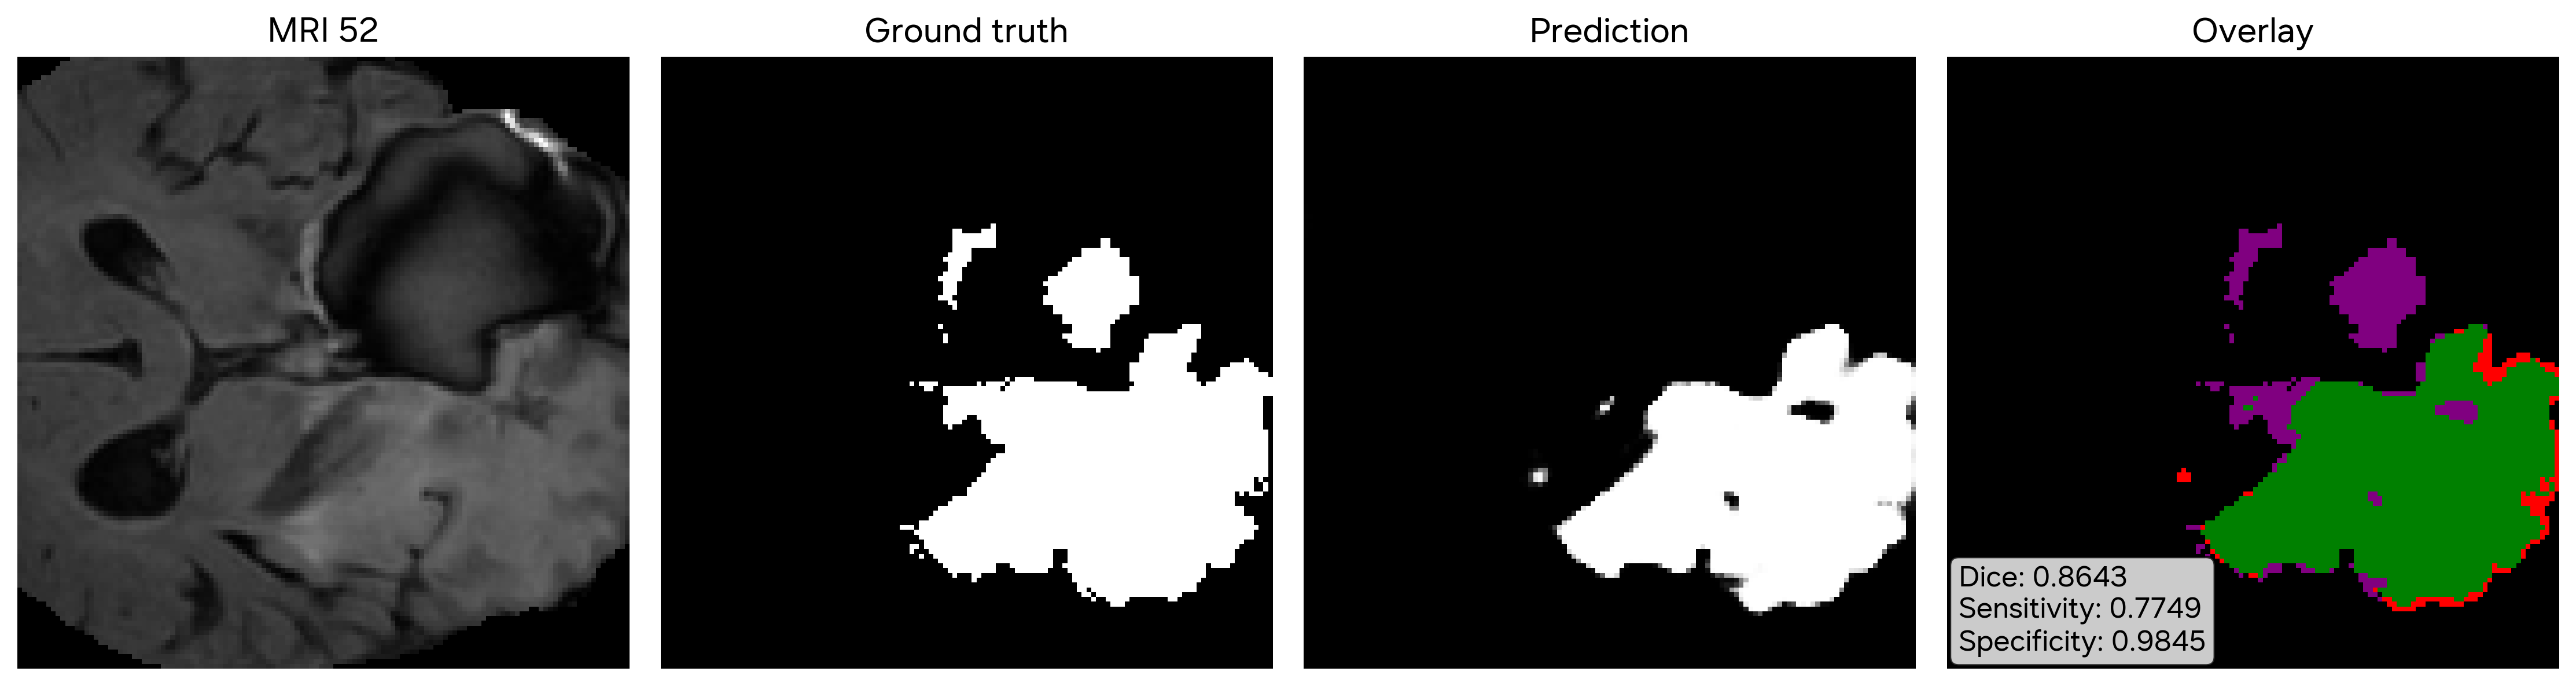

Index 95: Elapsed time = 42.3920 msecs, Dice coefficient = 0.9248, Sensitivity = 0.9606, Specificity = 0.9899

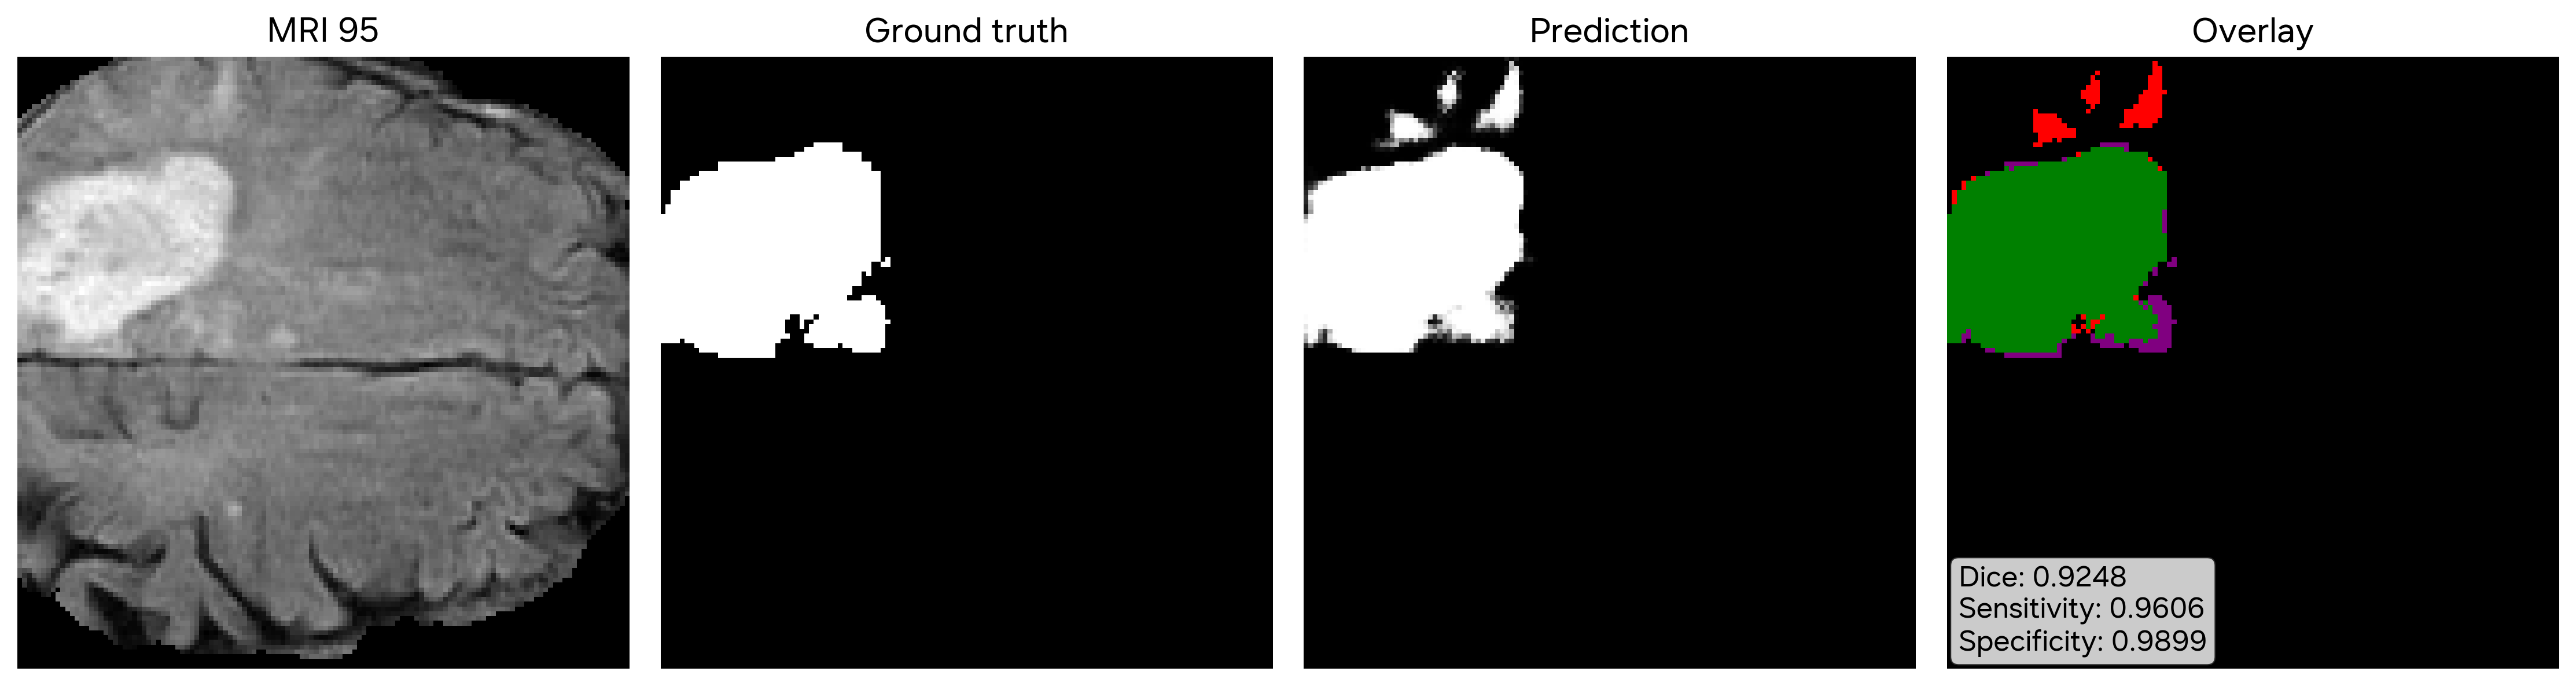

Index 24: Elapsed time = 28.0697 msecs, Dice coefficient = 0.8312, Sensitivity = 0.8888, Specificity = 0.9978

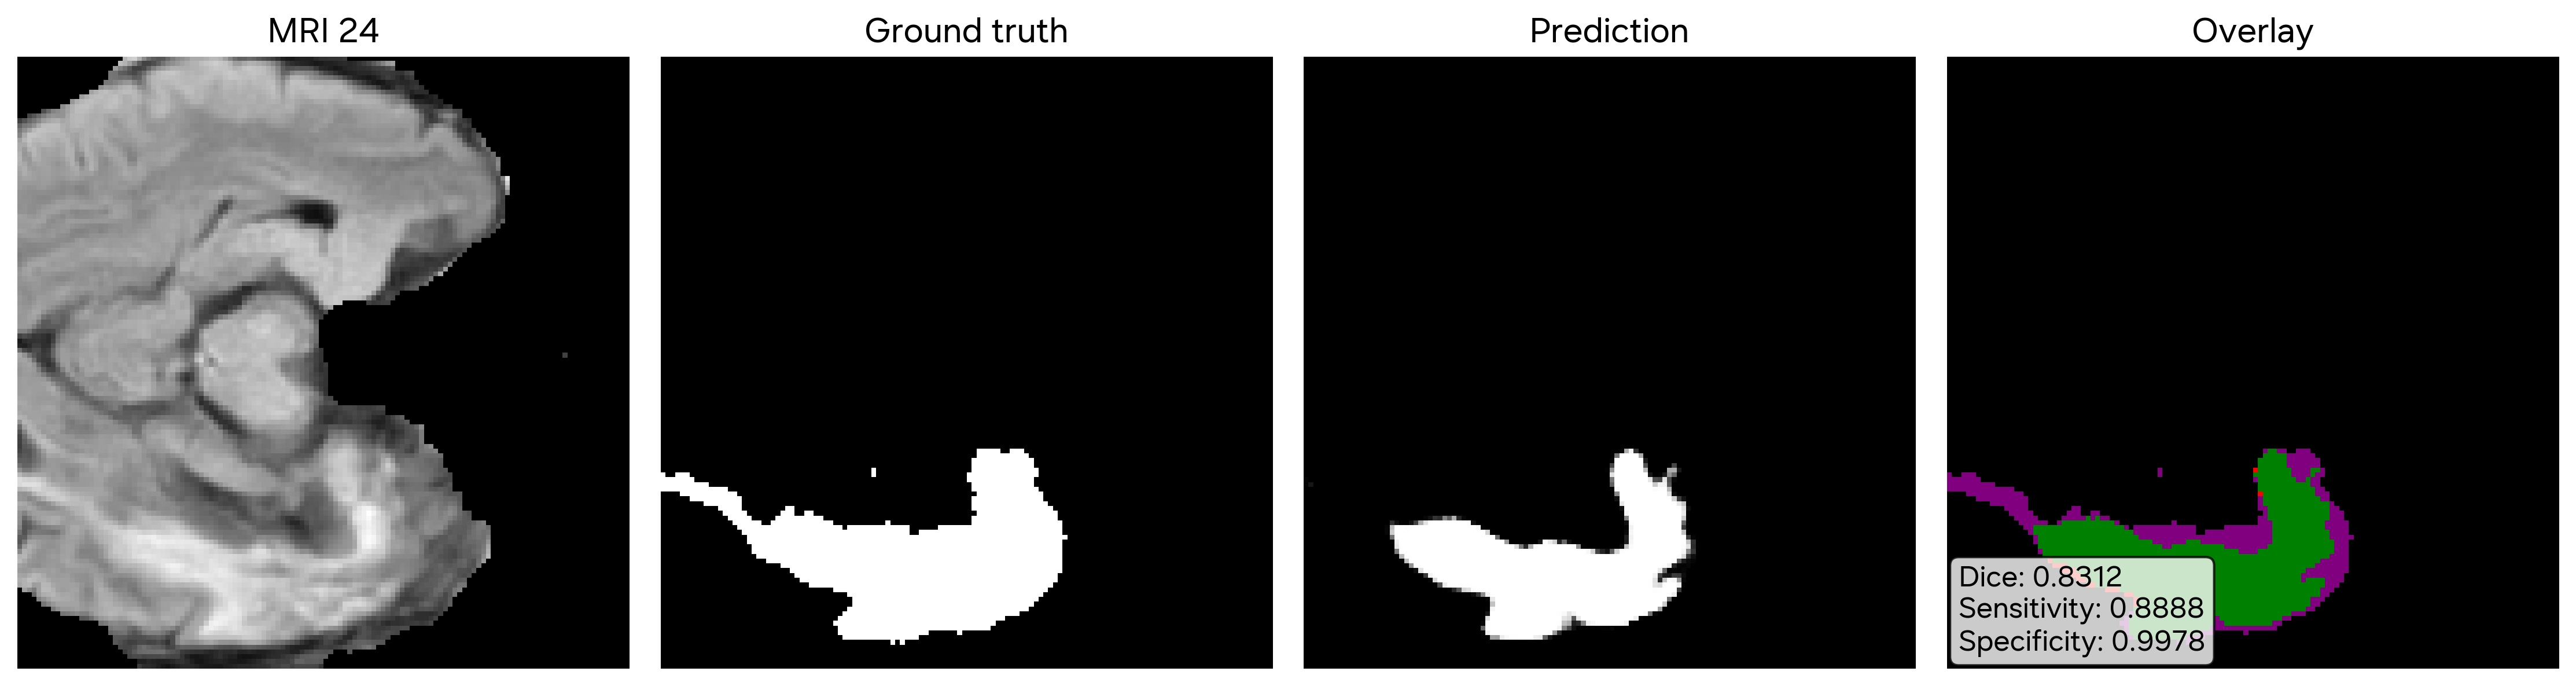

Index 66: Elapsed time = 28.6038 msecs, Dice coefficient = 0.9363, Sensitivity = 0.9897, Specificity = 0.9740

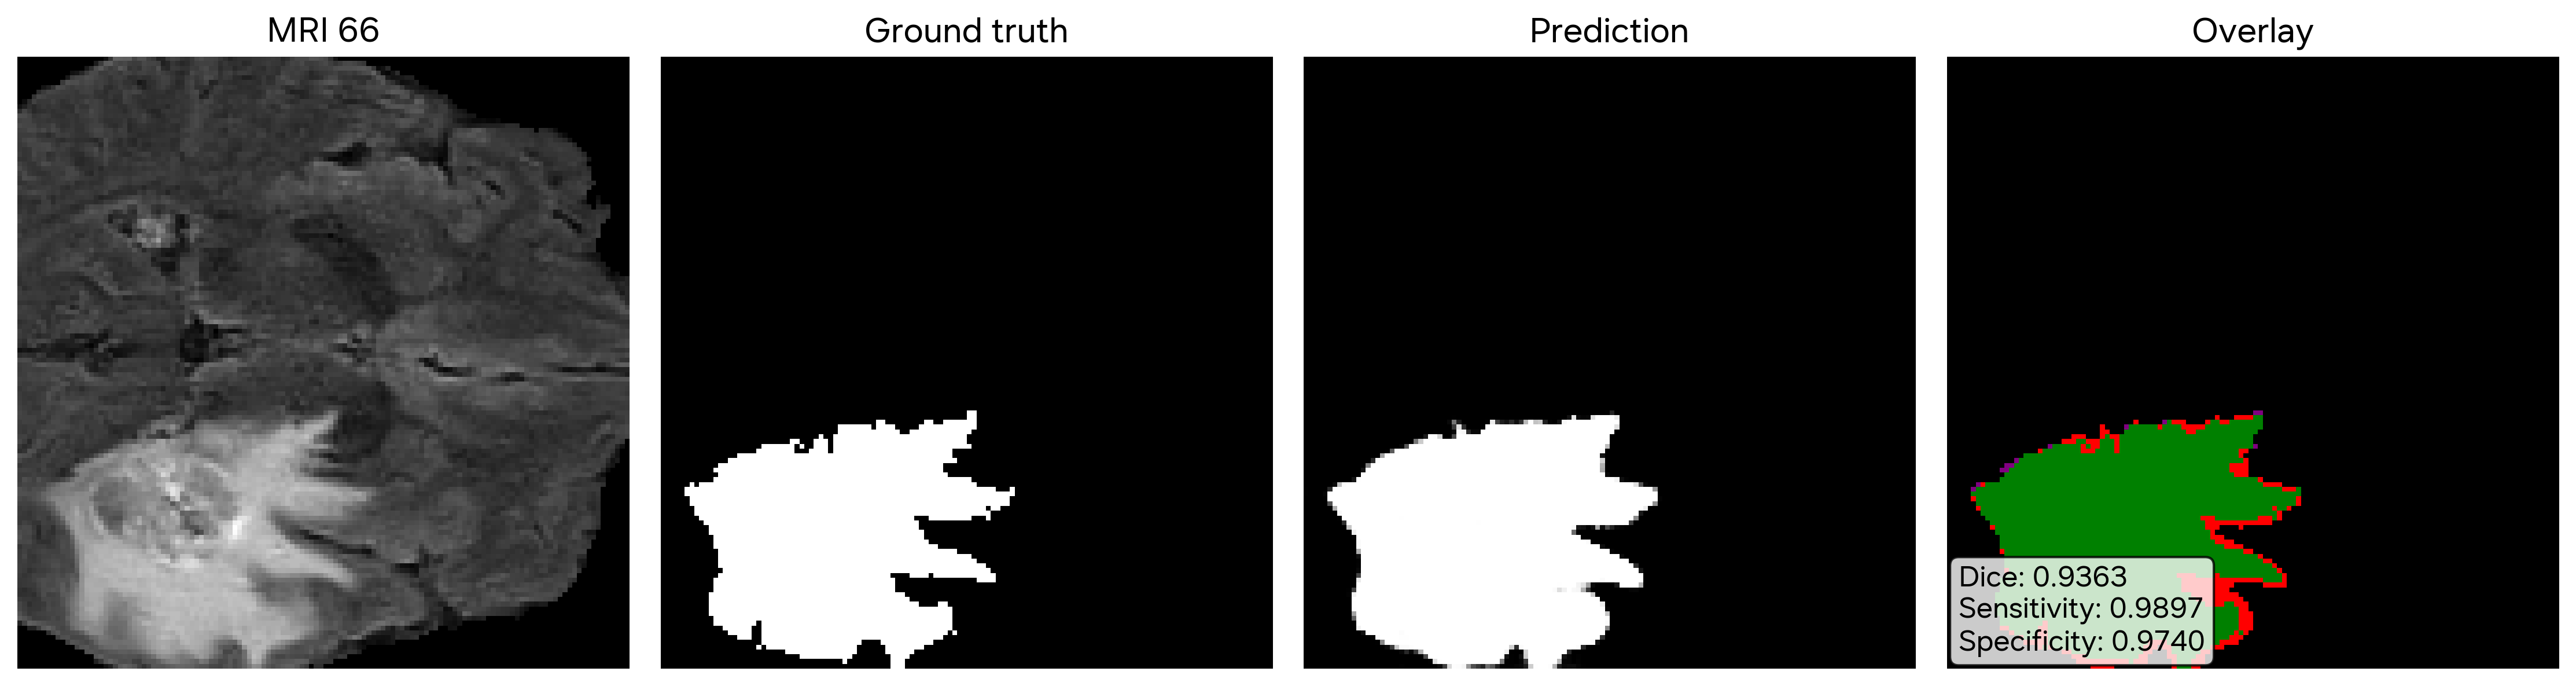

Index 62: Elapsed time = 28.2450 msecs, Dice coefficient = 0.9257, Sensitivity = 0.9138, Specificity = 0.9887

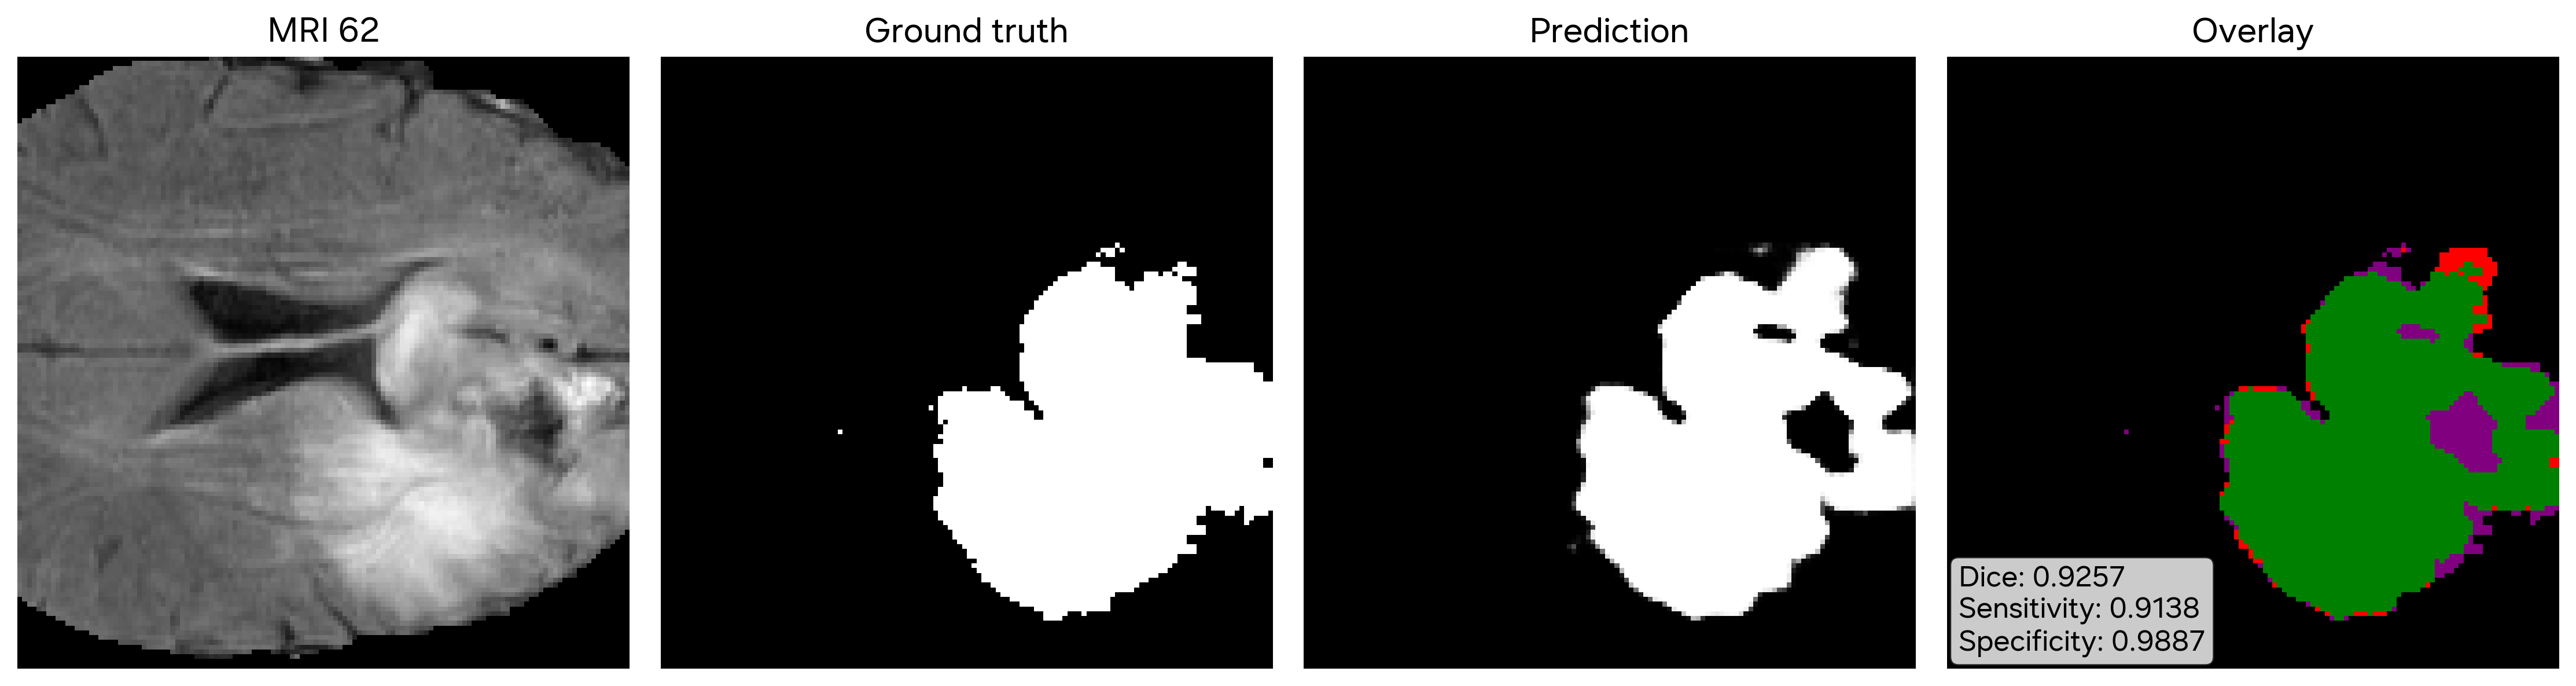

Index 86: Elapsed time = 33.3252 msecs, Dice coefficient = 0.9580, Sensitivity = 0.9720, Specificity = 0.9995

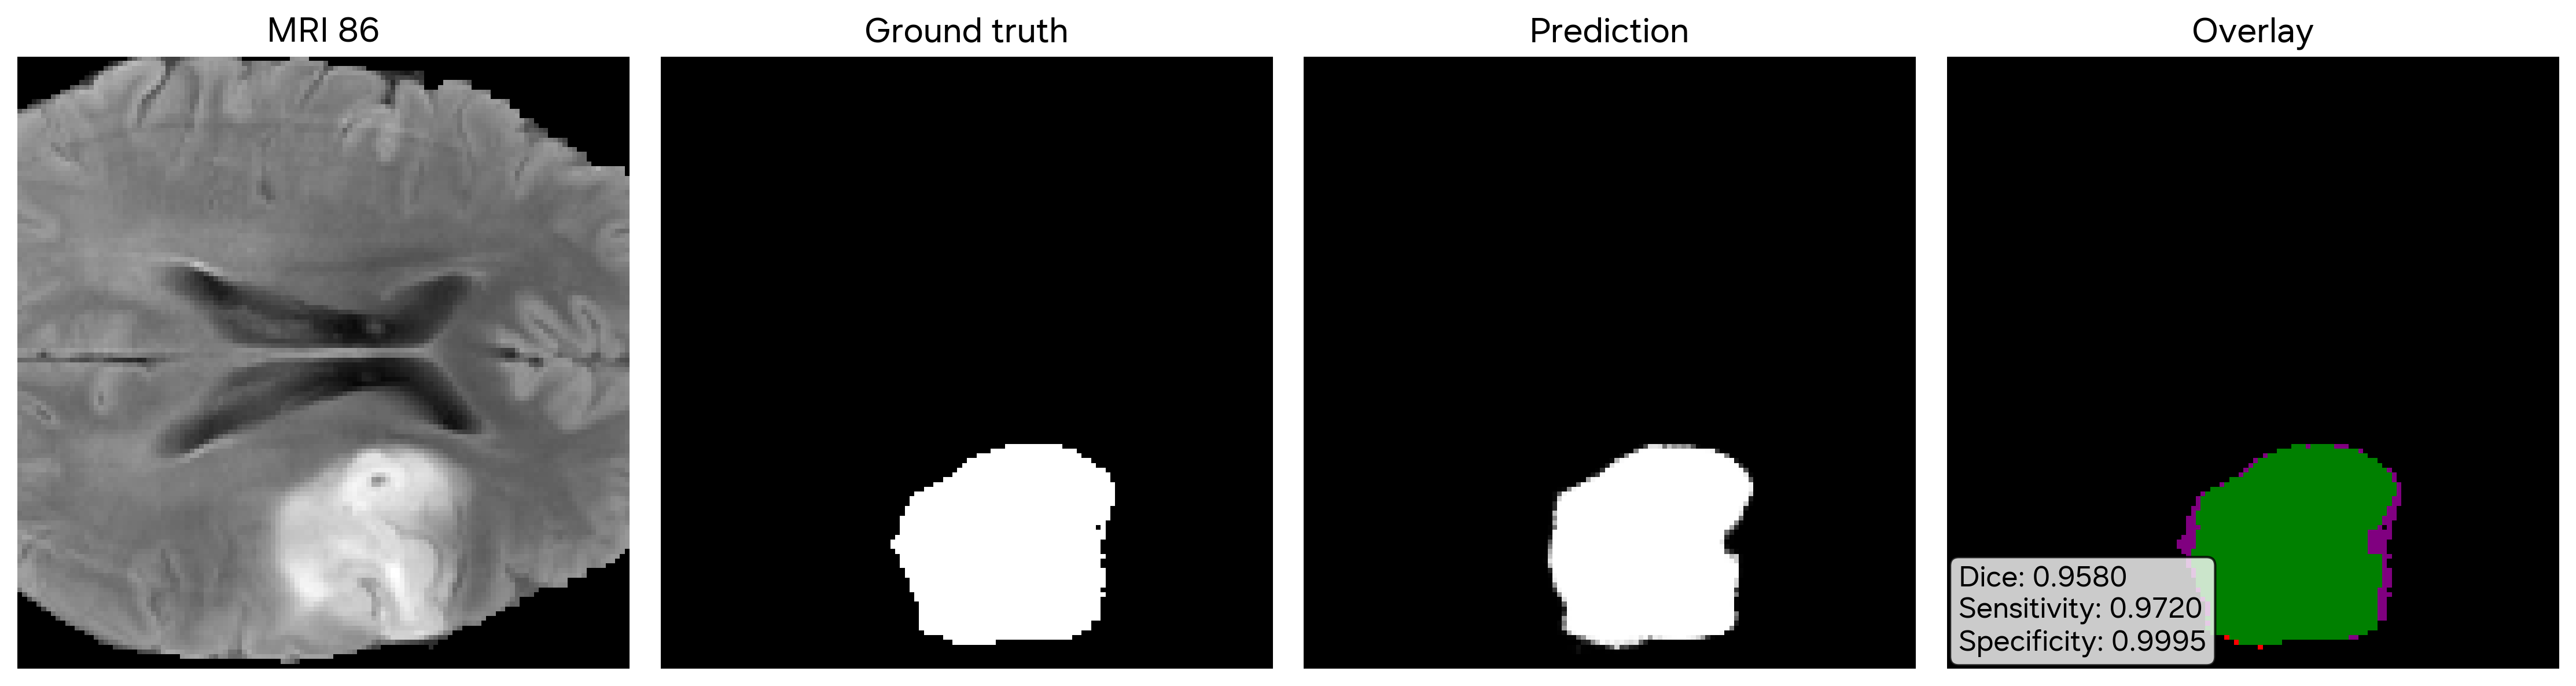

Index 63: Elapsed time = 30.1671 msecs, Dice coefficient = 0.8819, Sensitivity = 0.9965, Specificity = 0.9823

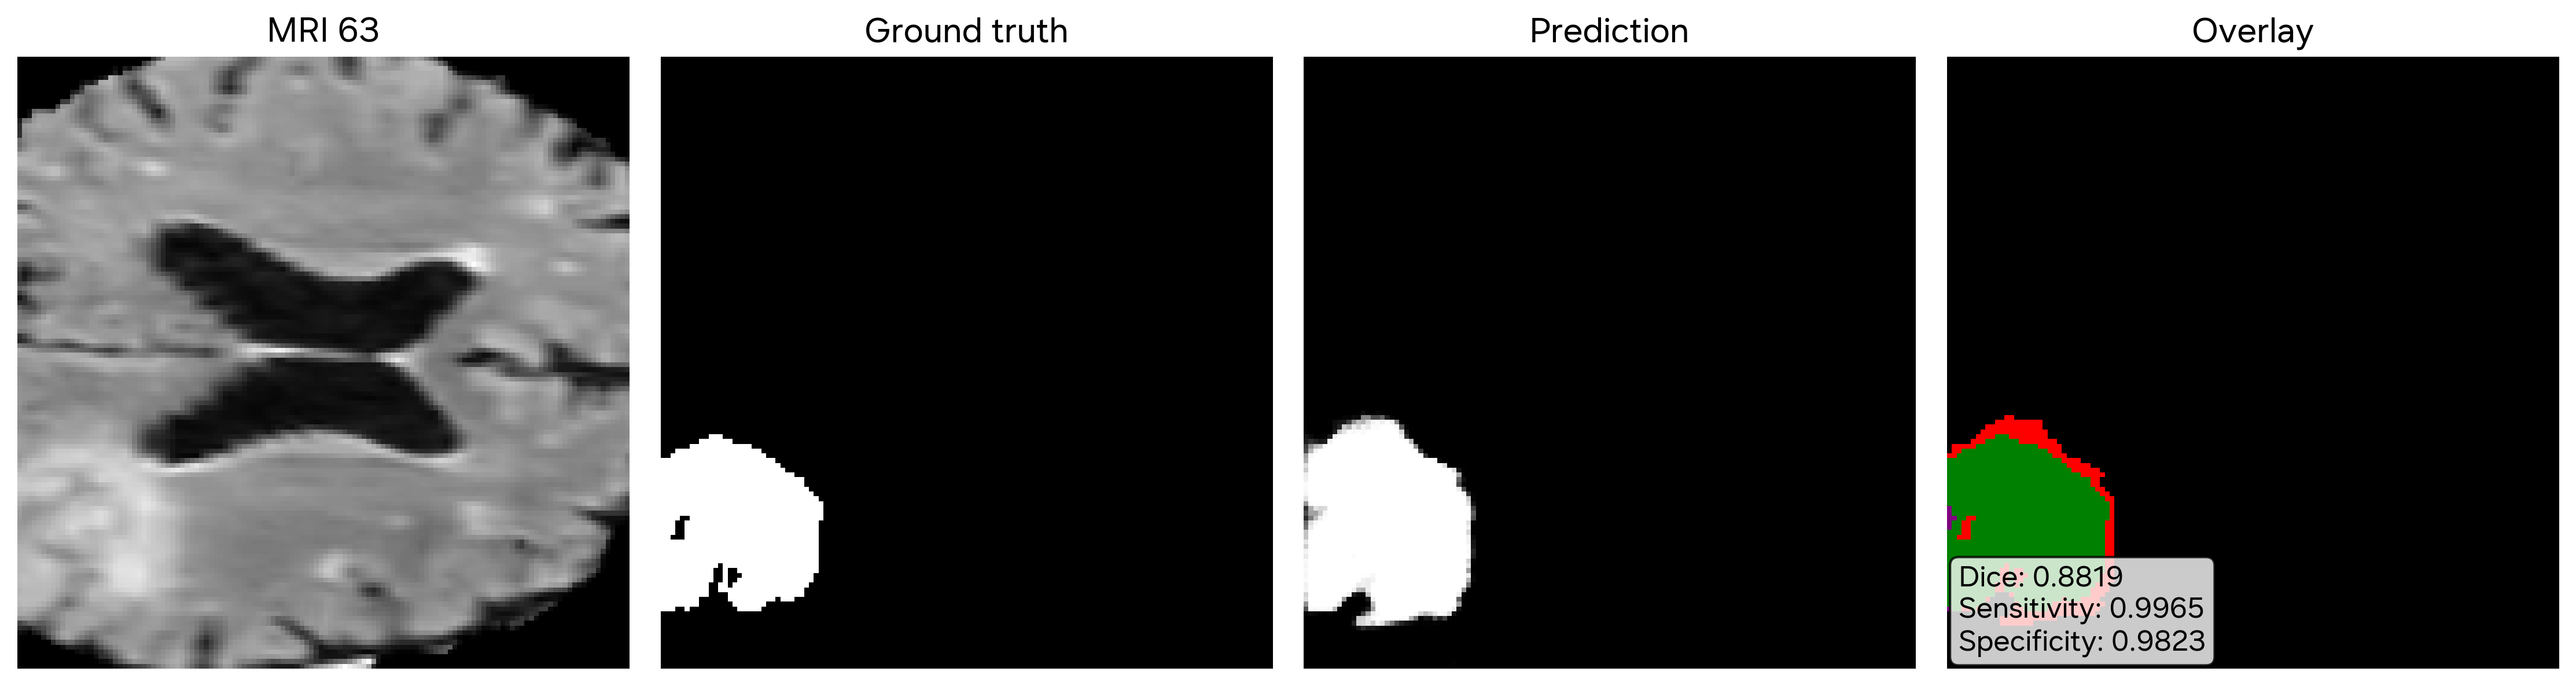

Index 70: Elapsed time = 28.3210 msecs, Dice coefficient = 0.9119, Sensitivity = 0.9300, Specificity = 0.9839

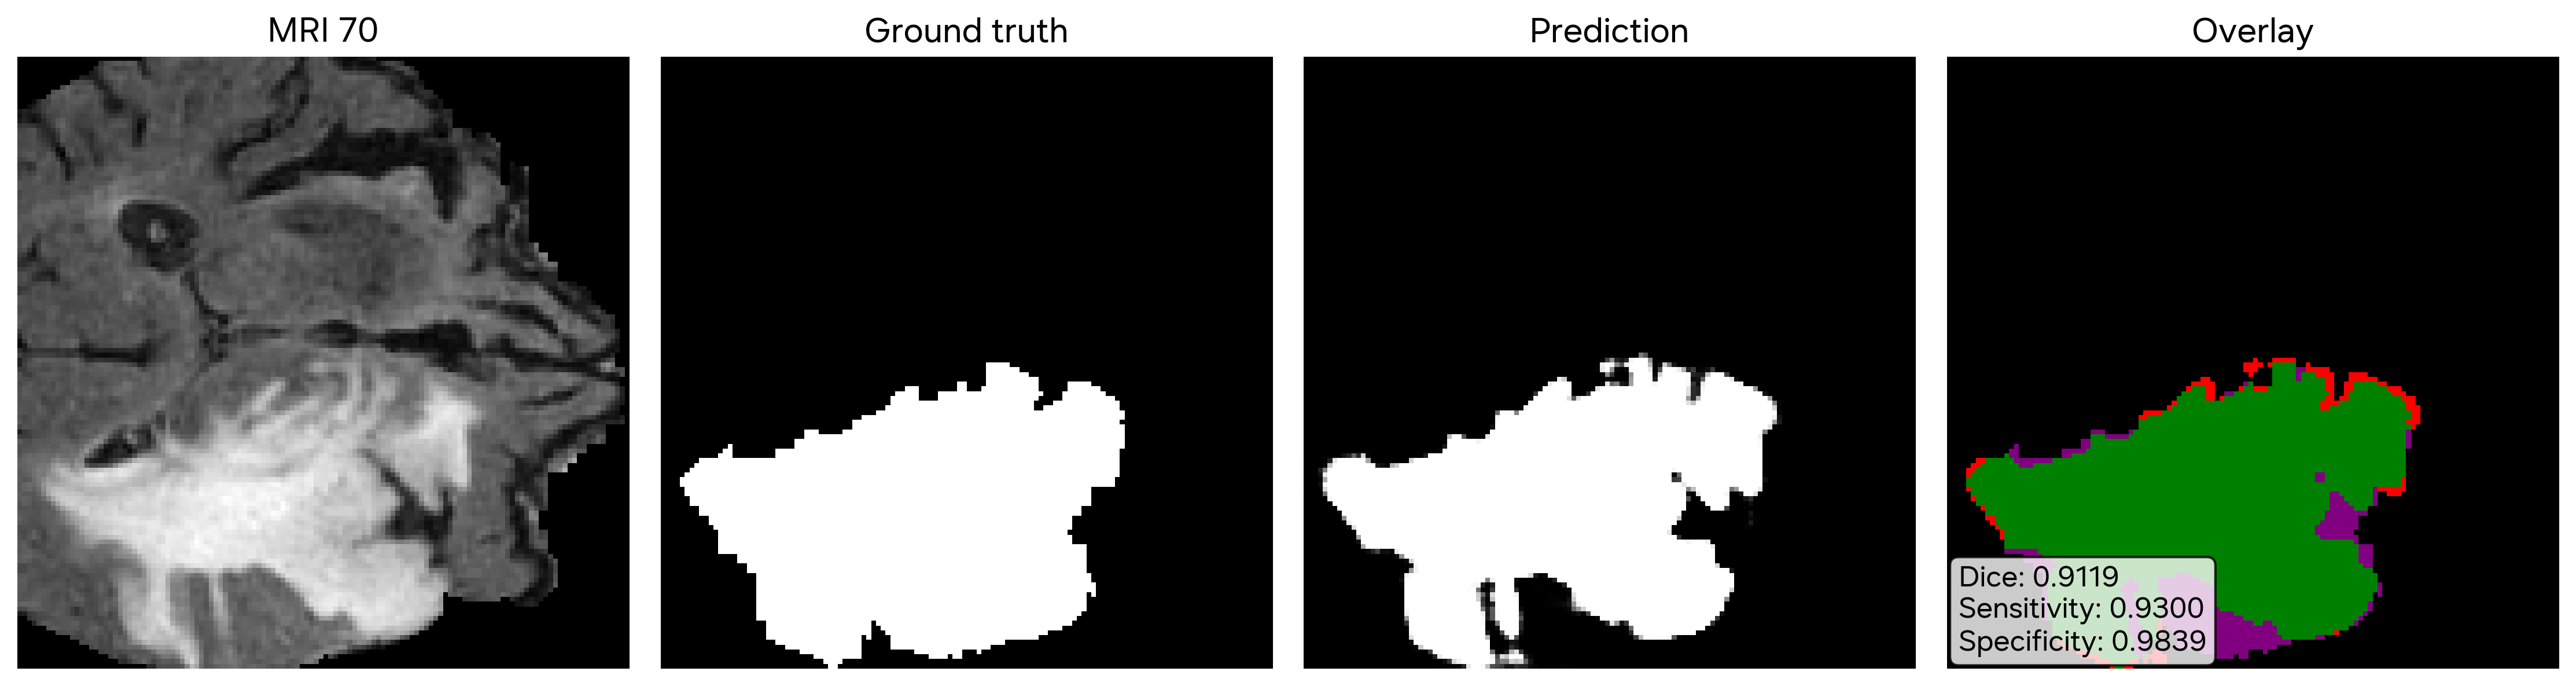

Index 36: Elapsed time = 36.4981 msecs, Dice coefficient = 0.9667, Sensitivity = 0.9258, Specificity = 0.9985

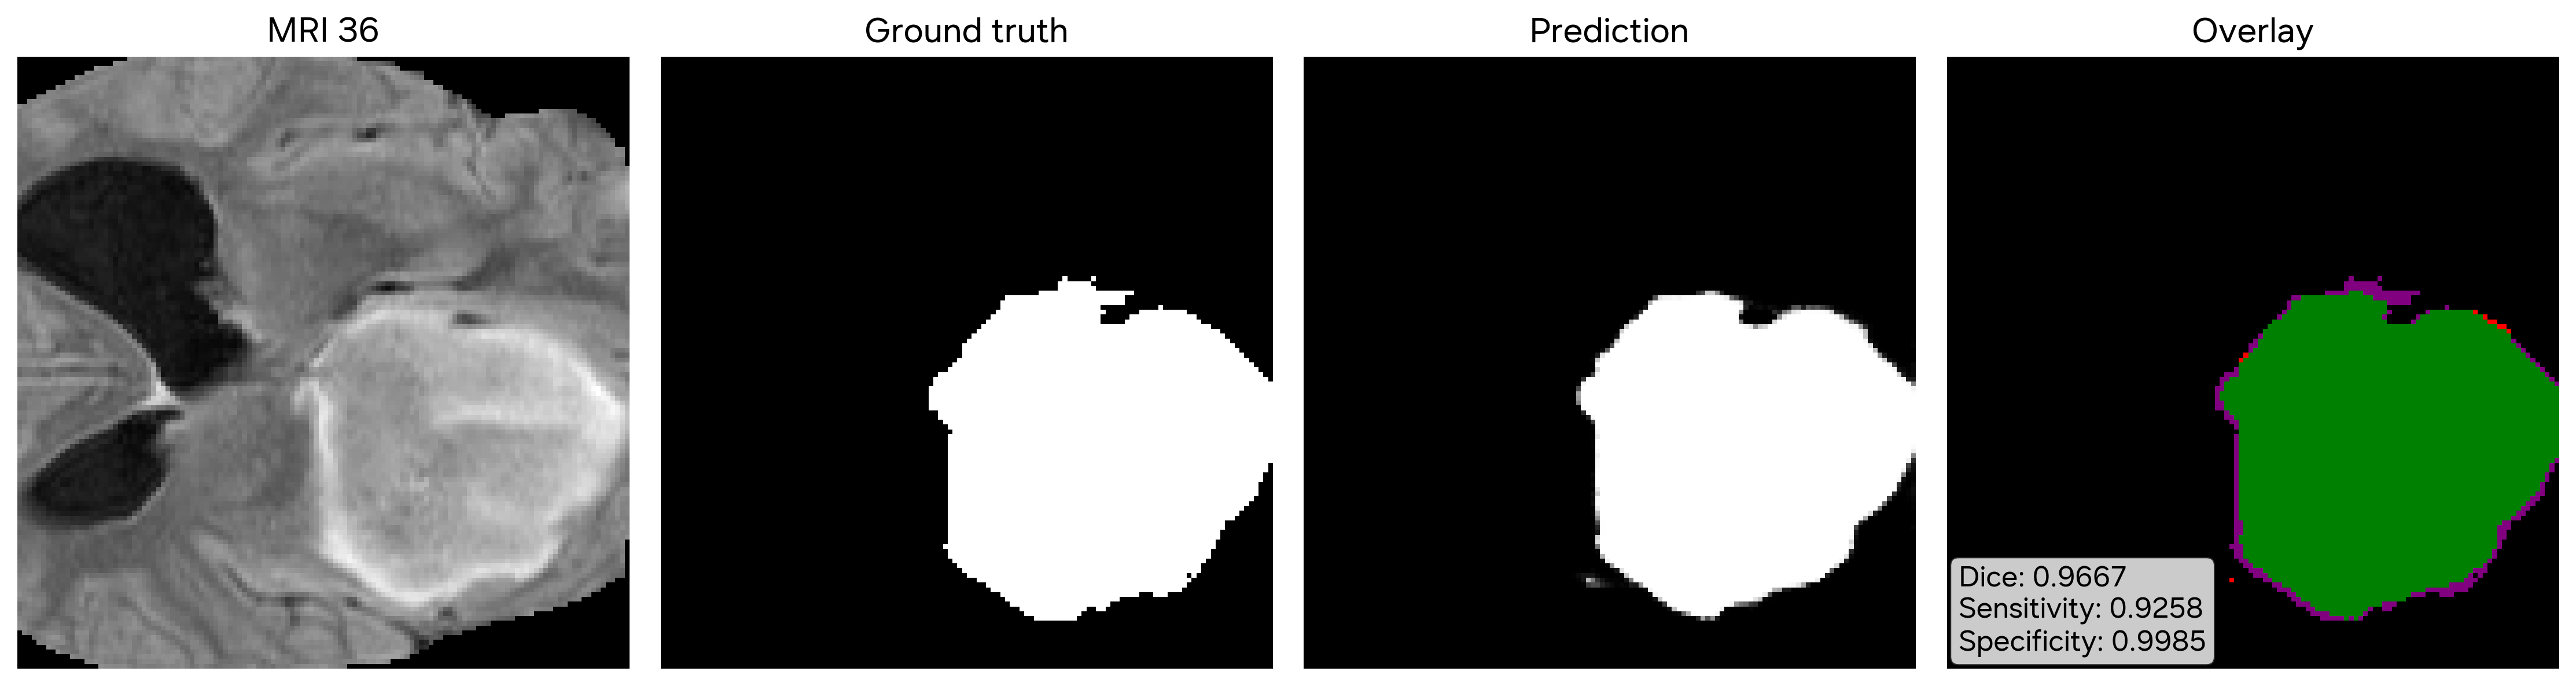

In [6]:
for i in range(10):
    plot_results(ds_test)